# Importation des packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import seaborn as sns
from matplotlib_venn import venn2, venn3
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

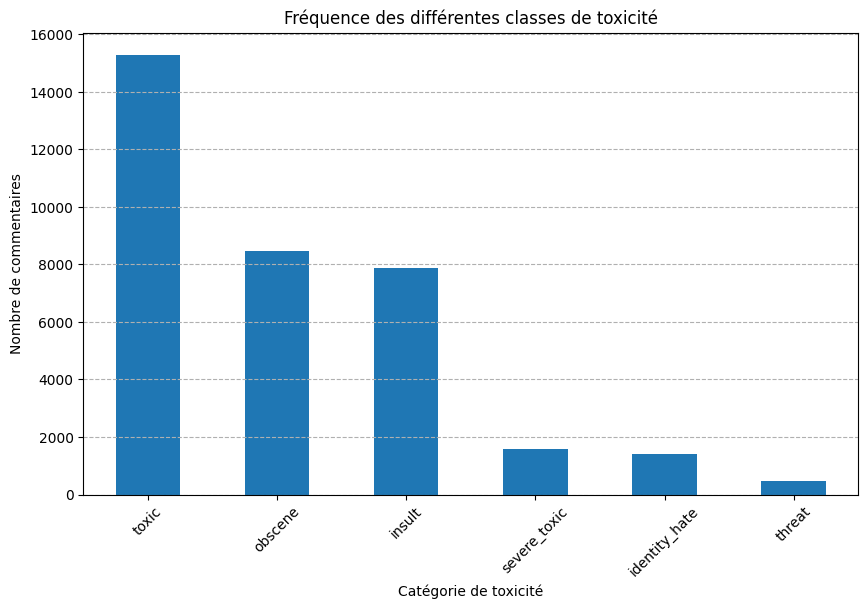

In [ ]:
# Calcul des fréquences pour chaque catégorie de toxicité
frequences_classes = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().sort_values(ascending=False)

# Visualisation via histogramme
plt.figure(figsize=(10, 6))
frequences_classes.plot(kind='bar')
plt.title('Fréquence des différentes classes de toxicité')
plt.xlabel('Catégorie de toxicité')
plt.ylabel('Nombre de commentaires')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

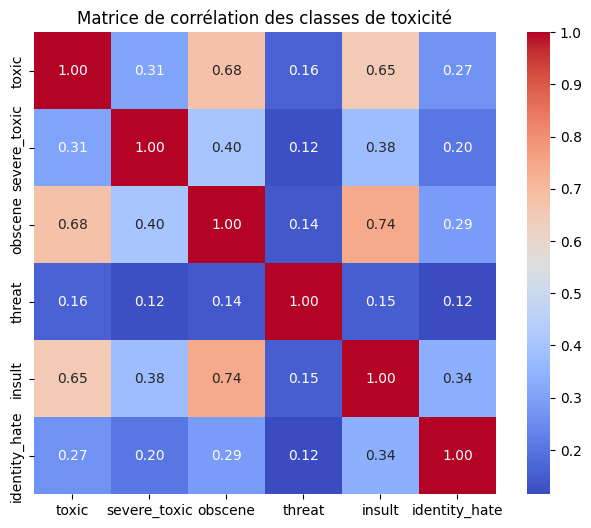

In [ ]:
# Matrice de corrélation
correlation_matrix = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Visualisation matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Matrice de corrélation des classes de toxicité')
plt.show()

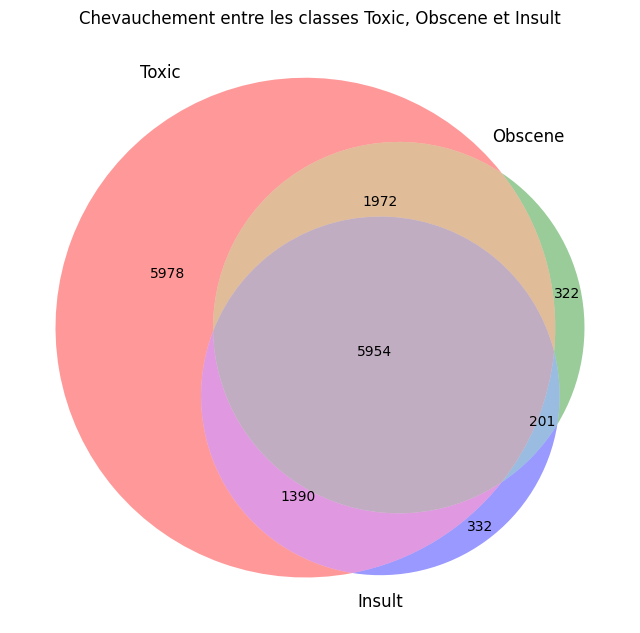

In [ ]:
# Chevauchement entre 'toxic', 'obscene' et 'insult'
set_toxic = set(data[data['toxic'] == 1].index)
set_obscene = set(data[data['obscene'] == 1].index)
set_insult = set(data[data['insult'] == 1].index)

# Diagramme de Venn pour 3 ensembles
plt.figure(figsize=(8, 8))
venn3([set_toxic, set_obscene, set_insult], ('Toxic', 'Obscene', 'Insult'))
plt.title('Chevauchement entre les classes Toxic, Obscene et Insult')
plt.show()

In [ ]:
# Calcul longueur des commentaires
data['comment_length'] = data['comment_text'].apply(len)

# Calcul longueur des commentaires par catégories
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for category in categories:
    mean_length = data.loc[data[category] == 1, 'comment_length'].mean()
    print(f"Longueur moyenne des commentaires pour {category}: {mean_length:.2f}")

Longueur moyenne des commentaires pour toxic: 295.25
Longueur moyenne des commentaires pour severe_toxic: 453.64
Longueur moyenne des commentaires pour obscene: 286.78
Longueur moyenne des commentaires pour threat: 307.74
Longueur moyenne des commentaires pour insult: 277.28
Longueur moyenne des commentaires pour identity_hate: 308.54


In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))

def nettoyer_texte(texte):
    # Supprimer la ponctuation et les nombres, mettre en minuscule
    texte = re.sub(r'[^a-zA-Z\s]', '', texte, re.I|re.A)
    texte = texte.lower()
    texte = texte.strip()
    # Tokenisation simple par espaces et suppression des mots vides
    mots = [mot for mot in texte.split() if mot not in stop_words]
    return mots


for category in categories:
    # Filtrer les commentaires pour chaque catégorie
    commentaires = data.loc[data[category] == 1, 'comment_text']
    tous_mots = []

    # Nettoyer et extraire les mots de chaque commentaire
    for commentaire in commentaires:
        mots = nettoyer_texte(commentaire)
        tous_mots.extend(mots)

    # Comptage mots les plus fréquents
    compteur_mots = Counter(tous_mots)
    mots_frequents = compteur_mots.most_common(10)
    print(f"Mots les plus fréquents pour {category}: {mots_frequents}")

Mots les plus fréquents pour toxic: [('fuck', 8616), ('dont', 3555), ('shit', 3485), ('like', 3476), ('nigger', 3289), ('fucking', 3194), ('wikipedia', 3140), ('suck', 2986), ('go', 2834), ('hate', 2614)]
Mots les plus fréquents pour severe_toxic: [('fuck', 6048), ('suck', 2291), ('shit', 1878), ('faggot', 1570), ('ass', 1402), ('u', 1383), ('fucking', 1374), ('go', 1240), ('die', 1020), ('nigger', 1011)]
Mots les plus fréquents pour obscene: [('fuck', 8541), ('shit', 3100), ('fucking', 3098), ('suck', 2773), ('nigger', 2721), ('go', 2118), ('ass', 2094), ('u', 2047), ('dont', 1759), ('like', 1528)]
Mots les plus fréquents pour threat: [('die', 1030), ('kill', 504), ('ass.', 425), ('ass', 344), ('going', 294), ('block', 170), ('must', 166), ('jim', 158), ('wales', 157), ('supertrll', 150)]
Mots les plus fréquents pour insult: [('fuck', 6624), ('nigger', 2774), ('fucking', 2712), ('suck', 2546), ('go', 2210), ('u', 1950), ('fat', 1924), ('faggot', 1805), ('dont', 1622), ('shit', 1582)]


# Importation des packages

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Préparation des données

In [ ]:
# Chargement des données
train = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')

In [ ]:
#stopwords et wordnet
nltk.download('stopwords')
nltk.download('wordnet')

# Gestion des valeurs manquantes
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

# Définition de la fonction de tokenisation
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Suppression des caractères inutiles et mise en minuscule
def tokenize(s):
    s = s.lower()
    s = re.sub('\s+', ' ', s)
    s = re.sub(r'\d+', '', s)

    # Tokenisation
    tokens = re_tok.sub(r' \1 ', s).split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Définition des colonnes de label
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Échantillonnage aléatoire de 30% des données d'entraînement et de test
train_sampled = train.sample(frac=0.3, random_state=42)
test_sampled = test.sample(frac=0.3, random_state=42)

# TF IDF
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode',
                      use_idf=1, smooth_idf=1, sublinear_tf=1)

# Création colonne 'is_toxic'
train_sampled['is_toxic'] = train_sampled[label_cols].max(axis=1)

# Vectorisation des commentaires
trn_term_doc = vec.fit_transform(train_sampled['comment_text'])
test_term_doc = vec.transform(test_sampled['comment_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné : 0.10


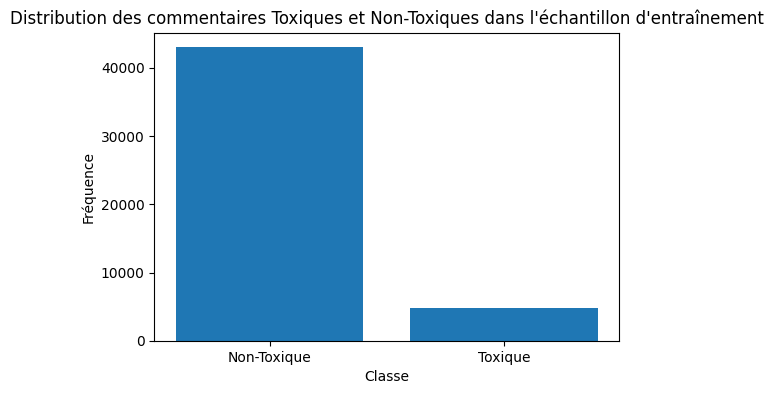

In [ ]:
# Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné
proportion_toxic_sampled = train_sampled['is_toxic'].mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement échantillonné : {proportion_toxic_sampled:.2f}')

# Affichage des distributions
plt.figure(figsize=(6, 4))
plt.hist(train_sampled['is_toxic'], bins=np.arange(-0.5, 2, 1), rwidth=0.8)
plt.title('Distribution des commentaires Toxiques et Non-Toxiques dans l\'échantillon d\'entraînement')
plt.xticks([0, 1], ['Non-Toxique', 'Toxique'])
plt.xlabel('Classe')
plt.ylabel('Fréquence')
plt.show()

TEST CONSTANT

In [ ]:
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Préparation des données
corpus = list(zip(train_sampled['comment_text'].values, train_sampled['is_toxic'].values))

# Mélange des données pour garantir la randomisation
random.shuffle(corpus)

# Extraction des commentaires et des labels du corpus
sentences = [str(item[0]) for item in corpus]
labels = [item[1] for item in corpus]

# Configuration des paramètres de tokenisation et de séquence
max_length = 100
padding_type = 'post'
trunc_type = 'post'
oov_tok = "<OOV>"

# Tokenisation
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

# Conversion des textes en séquences et application du padding
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Division des données en ensembles d'entraînement et de test avec stratification
training_sequences, test_sequences, training_labels, test_labels = train_test_split(
    padded, labels, test_size=0.2, stratify=labels, random_state=42)

# Conversion des labels en numpy arrays pour la compatibilité avec Keras
from tensorflow.keras.utils import to_categorical

training_labels = to_categorical(training_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)


Epoch 1/5
1197/1197 [==============================] - 54s 41ms/step - loss: 0.1164 - accuracy: 0.8959 - val_loss: 0.0875 - val_accuracy: 0.8984
Epoch 2/5
1197/1197 [==============================] - 20s 17ms/step - loss: 0.0493 - accuracy: 0.9496 - val_loss: 0.0401 - val_accuracy: 0.9596
Epoch 3/5
1197/1197 [==============================] - 16s 13ms/step - loss: 0.0218 - accuracy: 0.9776 - val_loss: 0.0405 - val_accuracy: 0.9574
Epoch 4/5
1197/1197 [==============================] - 16s 14ms/step - loss: 0.0101 - accuracy: 0.9904 - val_loss: 0.0555 - val_accuracy: 0.9480
Epoch 5/5
300/300 [==============================] - 1s 5ms/step - loss: 0.0744 - accuracy: 0.9369
Test Loss: 0.0744, Test Accuracy: 0.9369


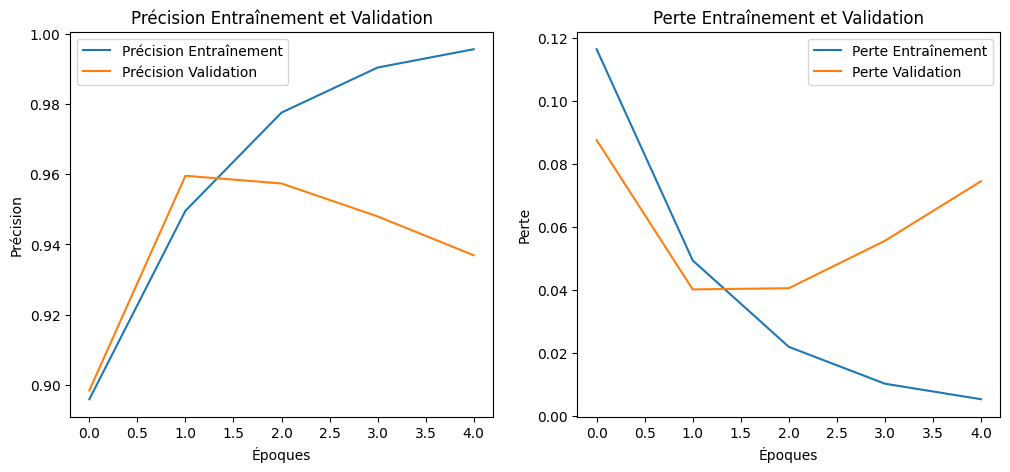

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

# Construction du modèle
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_length),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(6, activation='sigmoid')  # Utilisation de 'sigmoid' pour la classification multilabel
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    training_sequences,
    training_labels,
    epochs=5,
    validation_data=(test_sequences, test_labels)
)

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Visualisation des résultats
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Précision Entraînement et Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title('Perte Entraînement et Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Configuration des paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le token OOV
embedding_dim = 100
max_length = 100  # Assurez-vous que cela correspond à la configuration de `pad_sequences`
padding_type = 'post'
trunc_type = 'post'

# Création du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())  # Aplatit la sortie de l'embedding pour l'alimenter à une couche dense
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(training_sequences, np.array(training_labels), epochs=5, validation_data=(test_sequences, np.array(test_labels)))

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, np.array(test_labels))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          9962400   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                640064    
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10602529 (40.45 MB)
Trainable params: 10602529 (40.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1197/1197 [==============================] - 46s 37ms/step - loss: 0.1880 - accuracy: 0.9337 - val_loss: 0.1420 - val_accuracy: 0.949

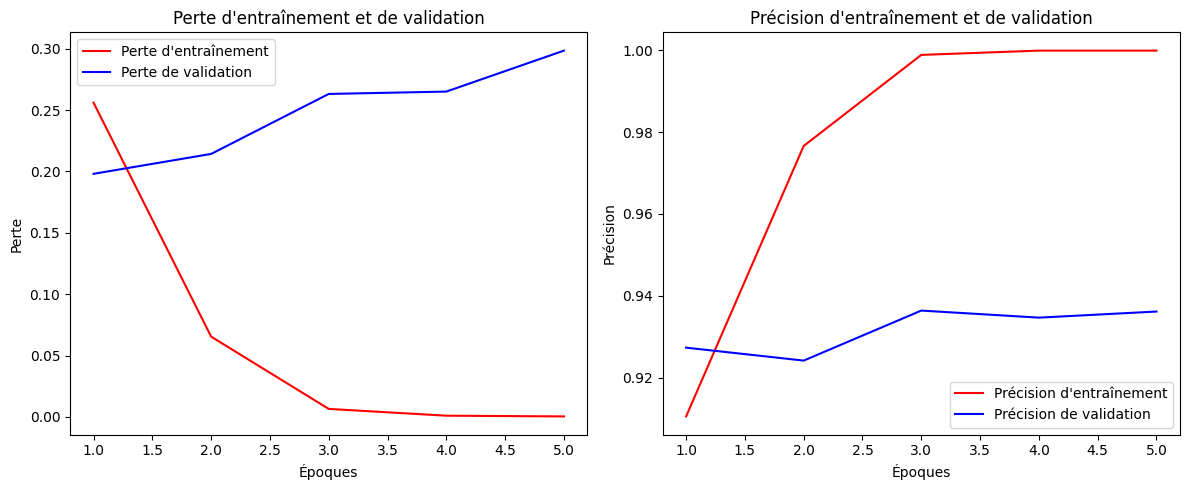

In [ ]:
import matplotlib.pyplot as plt

# Récupération de l'historique de l'entraînement
history_dict = history.history

# Extraction des courbes de perte pour l'entraînement et la validation
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Extraction des courbes de précision pour l'entraînement et la validation
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

# Détermination du nombre d'époques
epochs = range(1, len(loss_values) + 1)

# Tracé de la courbe de perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'r', label='Perte d\'entraînement')
plt.plot(epochs, val_loss_values, 'b', label='Perte de validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Tracé de la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'r', label='Précision d\'entraînement')
plt.plot(epochs, val_accuracy_values, 'b', label='Précision de validation')
plt.title('Précision d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Configuration des paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le token OOV
embedding_dim = 100
max_length = 100  # Assurez-vous que cela correspond à la configuration de `pad_sequences`
padding_type = 'post'
trunc_type = 'post'

# Création du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SimpleRNN(64))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(training_sequences, np.array(training_labels), epochs=5, validation_data=(test_sequences, np.array(test_labels)))

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, np.array(test_labels))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          9962400   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_22 (Dense)            (None, 256)               16640     
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 6)                 774       
                                                                 
Total params: 10023270 (38.24 MB)
Trainable params: 10023270 (38.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
# Configuration des paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Ajout de 1 pour le token OOV
embedding_dim = 100
max_length = 100  # Assurez-vous que cela correspond à la configuration de `pad_sequences`
padding_type = 'post'
trunc_type = 'post'

# Création du modèle
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle
history = model.fit(training_sequences, np.array(training_labels), epochs=5, validation_data=(test_sequences, np.array(test_labels)))

# Évaluation du modèle
loss, accuracy = model.evaluate(test_sequences, np.array(test_labels))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          9962400   
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 10054821 (38.36 MB)
Trainable params: 10054821 (38.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 5) vs (None, 1)).


# Modèle baseline: RandomForest


In [ ]:
y_train = train_sampled['is_toxic'].values

# Initialisation RandomForest
m = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
m.fit(trn_term_doc, y_train)


preds = m.predict_proba(test_term_doc)[:, 1]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    trn_term_doc,
    train_sampled['is_toxic'].values,
    test_size=0.6,  # 60% des données pour la validation
    random_state=42
)

# Ajustement du modèle
m = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
m.fit(X_train, y_train)

# Prédiction
preds_val = m.predict_proba(X_val)[:, 1]

# Convertir les probabilités avec un seuil de 50%
preds_binary_val = (preds_val > 0.5).astype(int)

# Calcul de l'accuracy sur l'ensemble de validation
accuracy_val = accuracy_score(y_val, preds_binary_val)
print(f'Accuracy sur l\'ensemble de validation: {accuracy_val:.4f}')

Accuracy sur l'ensemble de validation: 0.8990


# Entraînement du modèle baseline

# Itération de la modélisation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Création de la colonne 'is_toxic' pour l'ensemble d'entraînement
train['is_toxic'] = train[label_cols].max(axis=1)

# Préparation des données pour l'échantillonnage stratifié de l'ensemble d'entraînement
X_train = train['comment_text']
y_train = train['is_toxic']

# Échantillonnage stratifié pour créer un ensemble d'entraînement et un ensemble de validation
X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

# Vectorisation TF-IDF
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode',
                      use_idf=1, smooth_idf=1, sublinear_tf=1)

# Application de TF-IDF sur les échantillons
trn_term_doc = vec.fit_transform(X_train_sampled)
val_term_doc = vec.transform(X_val)

# Entraînement du modèle RandomForest
model = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=18, random_state=21)
model.fit(trn_term_doc, y_train_sampled)

# Évaluation du modèle sur l'ensemble de validation
preds_val = model.predict(val_term_doc)
accuracy_val = accuracy_score(y_val, preds_val)
print(f'Accuracy sur l\'ensemble de validation: {accuracy_val:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy sur l'ensemble de validation: 0.8983


Proportion de commentaires toxiques dans l'ensemble d'entraînement original : 0.10
Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné : 0.10


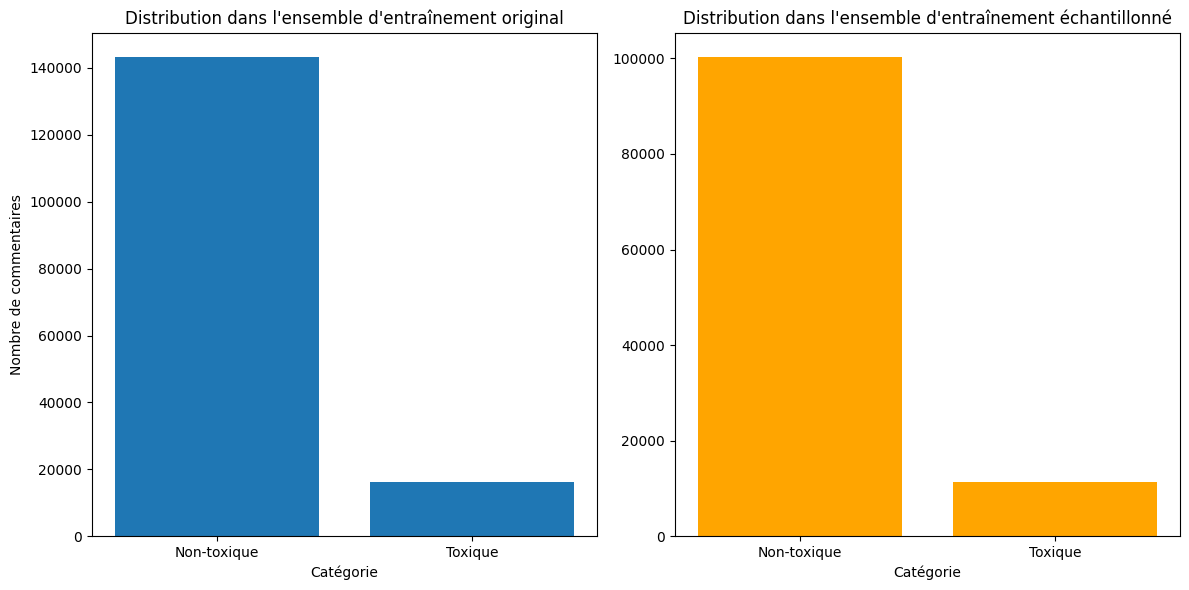

In [ ]:
# Proportion de commentaires toxiques dans l'ensemble d'entraînement original
original_proportion = y_train.mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement original : {original_proportion:.2f}')

# Proportion de commentaires toxiques dans l'ensemble d'entraînement échantillonné
sampled_proportion = y_train_sampled.mean()
print(f'Proportion de commentaires toxiques dans l\'ensemble d\'entraînement échantillonné : {sampled_proportion:.2f}')

# Affichage des distributions
plt.figure(figsize=(12, 6))

# Distribution dans l'ensemble d'entraînement original
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=np.arange(-0.5, 2, 1), rwidth=0.8)
plt.title('Distribution dans l\'ensemble d\'entraînement original')
plt.xticks([0, 1], ['Non-toxique', 'Toxique'])
plt.xlabel('Catégorie')
plt.ylabel('Nombre de commentaires')

# Distribution dans l'ensemble d'entraînement échantillonné
plt.subplot(1, 2, 2)
plt.hist(y_train_sampled, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='orange')
plt.title('Distribution dans l\'ensemble d\'entraînement échantillonné')
plt.xticks([0, 1], ['Non-toxique', 'Toxique'])
plt.xlabel('Catégorie')

plt.tight_layout()
plt.show()